In [1]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report, confusion_matrix

In [2]:
df= pd.read_csv(r"C:\Users\HandePC\Desktop\data.csv", sep=";")
df

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,9773,1,1,125.0,1,1,1,...,0,6,8,5,12.666667,0,15.5,2.8,-4.06,Graduate
4420,1,1,2,9773,1,1,120.0,105,1,1,...,0,6,6,2,11.000000,0,11.1,0.6,2.02,Dropout
4421,1,1,1,9500,1,1,154.0,1,37,37,...,0,8,9,1,13.500000,0,13.9,-0.3,0.79,Dropout
4422,1,1,1,9147,1,1,180.0,1,37,37,...,0,5,6,5,12.000000,0,9.4,-0.8,-3.12,Graduate


In [3]:
df.rename(columns = {'Nacionality':'Nationality', 'Age at enrollment':'Age'}, inplace = True)

In [4]:
df['Target'] = df['Target'].map({
    'Dropout':0,
    'Enrolled':1,
    'Graduate':2
})

In [5]:
Xcategorical_columns = df[["Marital status", "Application mode", "Course", "Daytime/evening attendance\t",
        "Previous qualification", "Previous qualification (grade)", "Nationality", "Mother's qualification",
        "Father's qualification", "Mother's occupation", "Father's occupation", "Admission grade", "Displaced",
        "Educational special needs", "Debtor", "Tuition fees up to date", "Gender", "Scholarship holder",
         "International"]]

Xnum= df[["Application order","Age", "Curricular units 1st sem (credited)","Curricular units 1st sem (enrolled)", "Curricular units 1st sem (evaluations)",
        "Curricular units 1st sem (approved)", "Curricular units 1st sem (grade)",
        "Curricular units 1st sem (without evaluations)", "Curricular units 2nd sem (credited)",
        "Curricular units 2nd sem (enrolled)", "Curricular units 2nd sem (evaluations)",
        "Curricular units 2nd sem (approved)", "Curricular units 2nd sem (grade)",
        "Curricular units 2nd sem (without evaluations)", "Unemployment rate", "Inflation rate", "GDP"]]
y = df['Target'] 


In [6]:
correlation_matrix = Xnum.corr()

# korelasyon katsayısını belirledik
high_correlation = (correlation_matrix > 0.6) & (correlation_matrix < 1.0)

# Koralasyona göre numeric verileri drop etme
columns_to_drop = [column for column in high_correlation.columns if any(high_correlation[column])]
Xnum_dropped = Xnum.drop(columns=columns_to_drop)

<Axes: >

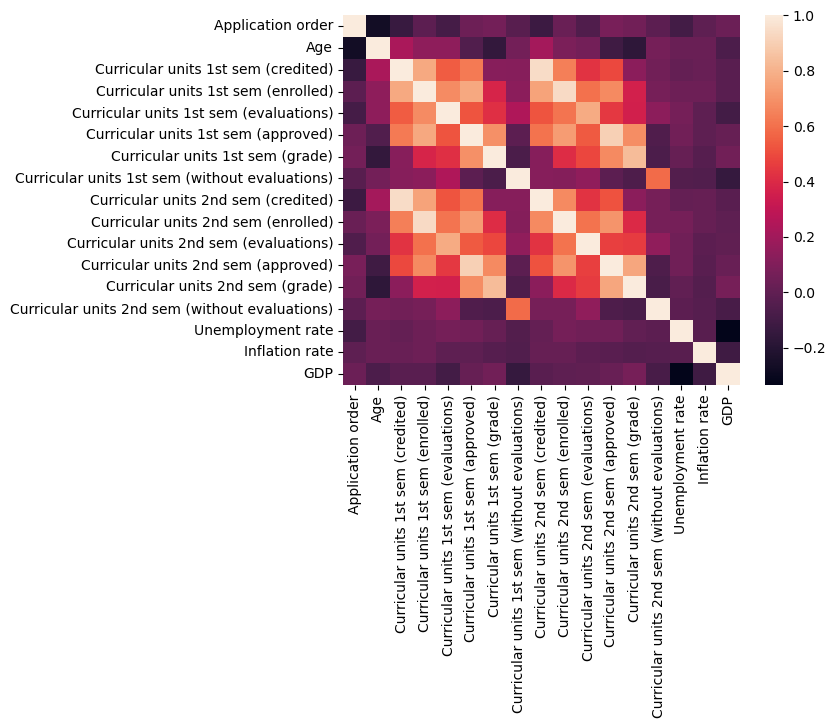

In [7]:
sns.heatmap(Xnum.corr())

In [8]:
def calculate_cramer_v_matrix(dataframe, categorical_columns):
    num_cat_columns = len(categorical_columns)
    cramer_v_matrix = np.zeros((num_cat_columns, num_cat_columns))

    for i in range(num_cat_columns):
        for j in range(i + 1, num_cat_columns):
            cat_variable1 = dataframe[categorical_columns[i]]
            cat_variable2 = dataframe[categorical_columns[j]]

            contingency_table = pd.crosstab(cat_variable1, cat_variable2)

            if contingency_table.shape[0] == 0 or contingency_table.shape[1] == 0:
                continue

            chi2, _, _, _ = chi2_contingency(contingency_table)

            n = sum(contingency_table.sum())
            min_val = min(len(contingency_table) - 1, len(contingency_table.columns) - 1)
            cramer_v = np.sqrt(chi2 / (n * min_val))

            cramer_v_matrix[i, j] = cramer_v
            cramer_v_matrix[j, i] = cramer_v

    return cramer_v_matrix

# Dataframe üzerinde Cramer's V katsayıları
cramer_v_matrix = calculate_cramer_v_matrix(df, Xcategorical_columns.columns)

cramer_v_df = pd.DataFrame(cramer_v_matrix, index=Xcategorical_columns.columns, columns=Xcategorical_columns.columns)

def drop_high_correlation(matrix, threshold, categorical_columns):
    upper_triangle = np.triu(matrix, k=1)

    # Eşik değerden yüksek korelasyona sahip hücreleri bul
    high_correlation_cells = np.where(upper_triangle > threshold)

    # Korelasyon değeri eşik değerinden yüksek olan değişken çiftlerini bul
    high_correlation_pairs = [(matrix.columns[i], matrix.columns[j]) for i, j in zip(*high_correlation_cells)]

    for variable1, variable2 in high_correlation_pairs:
        if variable1 not in matrix.columns or variable2 not in matrix.columns:
            continue

        # Drop işlemi
        if matrix[variable1].sum() >= matrix[variable2].sum():
            matrix = matrix.drop([variable1], axis=1)
            print(f"Dropped variable: {variable1}")
            categorical_columns.remove(variable1)

    return categorical_columns  # Güncellenmiş liste

# drop_high_correlation fonksiyonunu çağırırken Xcategorical_columns.columns kullanılabilir
categorical_columns = drop_high_correlation(cramer_v_df, threshold=0.3, categorical_columns=list(Xcategorical_columns.columns))

# Kalan kategorik değişkenleri yazdır
remaining_categorical_columns = categorical_columns
print("Remaining Categorical Columns:", remaining_categorical_columns)

Dropped variable: Application mode
Dropped variable: Course
Dropped variable: Previous qualification (grade)
Dropped variable: Mother's qualification
Dropped variable: Mother's occupation
Dropped variable: Admission grade
Remaining Categorical Columns: ['Marital status', 'Daytime/evening attendance\t', 'Previous qualification', 'Nationality', "Father's qualification", "Father's occupation", 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'International']


In [9]:
df["Target"] = df["Target"].apply(lambda x: x.split()[0] if isinstance(x, str) else x)

# Sütun adlarını birleştirme
selected_columns = remaining_categorical_columns + list(map(str, Xnum_dropped.columns)) + ["Target"]
df_updated = df[selected_columns].copy()

In [10]:
df_updated

,Marital status,Daytime/evening attendance\t,Previous qualification,Nationality,Father's qualification,Father's occupation,Displaced,Educational special needs,Debtor,Tuition fees up to date,...,Scholarship holder,International,Application order,Age,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,1,1,1,12,9,1,0,0,1,...,0,0,5,20,0,0,10.8,1.4,1.74,0
1,1,1,1,1,3,3,1,0,0,0,...,0,0,1,19,0,0,13.9,-0.3,0.79,2
2,1,1,1,1,37,9,1,0,0,0,...,0,0,5,19,0,0,10.8,1.4,1.74,0
3,1,1,1,1,37,3,1,0,0,1,...,0,0,2,20,0,0,9.4,-0.8,-3.12,2
4,2,0,1,1,38,9,0,0,0,1,...,0,0,1,45,0,0,13.9,-0.3,0.79,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,1,1,1,4,0,0,0,1,...,0,0,6,19,0,0,15.5,2.8,-4.06,2
4420,1,1,1,105,1,9,1,0,1,0,...,0,1,2,18,0,0,11.1,0.6,2.02,0
4421,1,1,1,1,37,9,1,0,0,1,...,1,0,1,30,0,0,13.9,-0.3,0.79,0
4422,1,1,1,1,37,4,1,0,0,1,...,1,0,1,20,0,0,9.4,-0.8,-3.12,2


In [11]:
df_updated.drop(df[df['Target'] == 1].index, inplace = True)
df_updated

,Marital status,Daytime/evening attendance\t,Previous qualification,Nationality,Father's qualification,Father's occupation,Displaced,Educational special needs,Debtor,Tuition fees up to date,...,Scholarship holder,International,Application order,Age,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,1,1,1,12,9,1,0,0,1,...,0,0,5,20,0,0,10.8,1.4,1.74,0
1,1,1,1,1,3,3,1,0,0,0,...,0,0,1,19,0,0,13.9,-0.3,0.79,2
2,1,1,1,1,37,9,1,0,0,0,...,0,0,5,19,0,0,10.8,1.4,1.74,0
3,1,1,1,1,37,3,1,0,0,1,...,0,0,2,20,0,0,9.4,-0.8,-3.12,2
4,2,0,1,1,38,9,0,0,0,1,...,0,0,1,45,0,0,13.9,-0.3,0.79,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,1,1,1,4,0,0,0,1,...,0,0,6,19,0,0,15.5,2.8,-4.06,2
4420,1,1,1,105,1,9,1,0,1,0,...,0,1,2,18,0,0,11.1,0.6,2.02,0
4421,1,1,1,1,37,9,1,0,0,1,...,1,0,1,30,0,0,13.9,-0.3,0.79,0
4422,1,1,1,1,37,4,1,0,0,1,...,1,0,1,20,0,0,9.4,-0.8,-3.12,2


In [12]:
df_updated['Dropout'] = df['Target'].apply(lambda x: 1 if x==0 else 0)
df_updated

,Marital status,Daytime/evening attendance\t,Previous qualification,Nationality,Father's qualification,Father's occupation,Displaced,Educational special needs,Debtor,Tuition fees up to date,...,International,Application order,Age,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target,Dropout
0,1,1,1,1,12,9,1,0,0,1,...,0,5,20,0,0,10.8,1.4,1.74,0,1
1,1,1,1,1,3,3,1,0,0,0,...,0,1,19,0,0,13.9,-0.3,0.79,2,0
2,1,1,1,1,37,9,1,0,0,0,...,0,5,19,0,0,10.8,1.4,1.74,0,1
3,1,1,1,1,37,3,1,0,0,1,...,0,2,20,0,0,9.4,-0.8,-3.12,2,0
4,2,0,1,1,38,9,0,0,0,1,...,0,1,45,0,0,13.9,-0.3,0.79,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,1,1,1,4,0,0,0,1,...,0,6,19,0,0,15.5,2.8,-4.06,2,0
4420,1,1,1,105,1,9,1,0,1,0,...,1,2,18,0,0,11.1,0.6,2.02,0,1
4421,1,1,1,1,37,9,1,0,0,1,...,0,1,30,0,0,13.9,-0.3,0.79,0,1
4422,1,1,1,1,37,4,1,0,0,1,...,0,1,20,0,0,9.4,-0.8,-3.12,2,0


In [13]:
df_updated['Dropout'] = df['Target'].apply(lambda x: 1 if x==0 else 0)
df_updated

,Marital status,Daytime/evening attendance\t,Previous qualification,Nationality,Father's qualification,Father's occupation,Displaced,Educational special needs,Debtor,Tuition fees up to date,...,International,Application order,Age,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target,Dropout
0,1,1,1,1,12,9,1,0,0,1,...,0,5,20,0,0,10.8,1.4,1.74,0,1
1,1,1,1,1,3,3,1,0,0,0,...,0,1,19,0,0,13.9,-0.3,0.79,2,0
2,1,1,1,1,37,9,1,0,0,0,...,0,5,19,0,0,10.8,1.4,1.74,0,1
3,1,1,1,1,37,3,1,0,0,1,...,0,2,20,0,0,9.4,-0.8,-3.12,2,0
4,2,0,1,1,38,9,0,0,0,1,...,0,1,45,0,0,13.9,-0.3,0.79,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,1,1,1,4,0,0,0,1,...,0,6,19,0,0,15.5,2.8,-4.06,2,0
4420,1,1,1,105,1,9,1,0,1,0,...,1,2,18,0,0,11.1,0.6,2.02,0,1
4421,1,1,1,1,37,9,1,0,0,1,...,0,1,30,0,0,13.9,-0.3,0.79,0,1
4422,1,1,1,1,37,4,1,0,0,1,...,0,1,20,0,0,9.4,-0.8,-3.12,2,0


C:\Users\HandePC\AppData\Local\Temp\ipykernel_8248\2788092735.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_updated['Dropout'], color = "blue")


<Axes: xlabel='Dropout', ylabel='Density'>

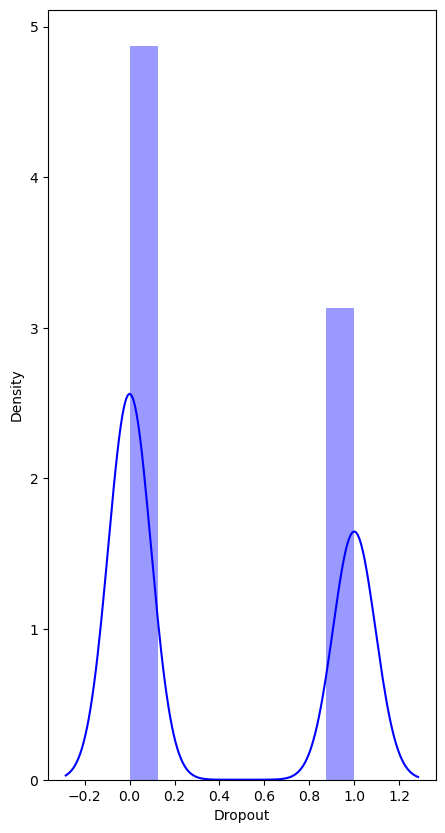

In [14]:
plt.figure(figsize=(5, 10))
sns.distplot(df_updated['Dropout'], color = "blue")

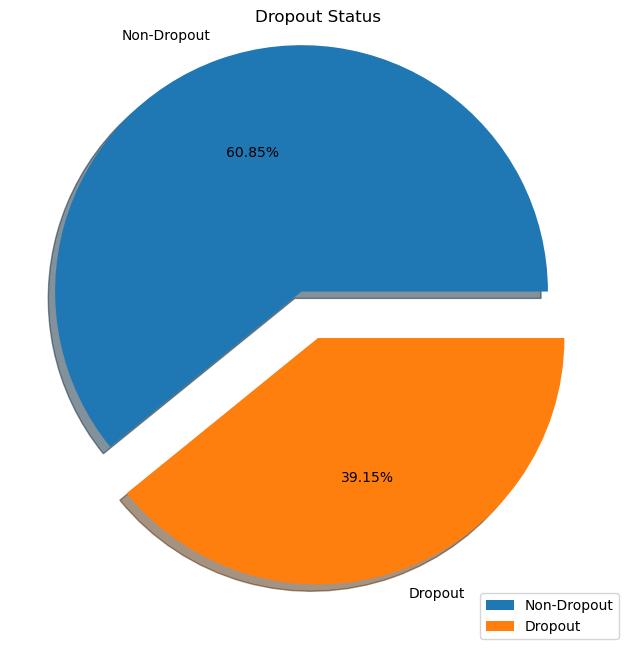

In [15]:
plt.figure(figsize=(8, 8))
plt.title("Dropout Status")
plt.pie(df_updated['Dropout'].value_counts(),  labels = ['Non-Dropout', 'Dropout'], explode = (0.2, 0.0), autopct='%1.2f%%', shadow = True)
plt.legend( loc = 'lower right')

In [16]:
x = df_updated.iloc[:, :20].values
#x = df[["Tuition fees up to date","Curricular units 1st sem (approved)","Curricular units 1st sem (grade)","Curricular units 2nd sem (approved)","Curricular units 2nd sem (grade)"]].values
print(x)
x = StandardScaler().fit_transform(x)
x

[[ 1.    1.    1.   ... 10.8   1.4   1.74]
 [ 1.    1.    1.   ... 13.9  -0.3   0.79]
 [ 1.    1.    1.   ... 10.8   1.4   1.74]
 ...
 [ 1.    1.    1.   ... 13.9  -0.3   0.79]
 [ 1.    1.    1.   ...  9.4  -0.8  -3.12]
 [ 1.    1.    1.   ... 12.7   3.7  -1.7 ]]


array([[-0.30068558,  0.35585028, -0.35242129, ..., -0.31131218,
         0.12161459,  0.77411864],
       [-0.30068558,  0.35585028, -0.35242129, ...,  0.85091858,
        -1.10607007,  0.35370412],
       [-0.30068558,  0.35585028, -0.35242129, ..., -0.31131218,
         0.12161459,  0.77411864],
       ...,
       [-0.30068558,  0.35585028, -0.35242129, ...,  0.85091858,
        -1.10607007,  0.35370412],
       [-0.30068558,  0.35585028, -0.35242129, ..., -0.83619059,
        -1.46715379, -1.37663355],
       [-0.30068558,  0.35585028, -0.35242129, ...,  0.4010228 ,
         1.78259971, -0.74822447]])

In [17]:
y = df_updated['Dropout'].values
y

array([1, 0, 1, ..., 1, 0, 0], dtype=int64)

In [24]:
print("X shape after fix:", x.shape)
print("y shape after fix:", y.shape)

X shape after fix: (3630, 20)
y shape after fix: (3630,)


In [25]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 123)

In [26]:
def perform(y_pred):
    print("Precision : ", precision_score(y_test, y_pred, average = 'micro'))
    print("Recall : ", recall_score(y_test, y_pred, average = 'micro'))
    print("Accuracy : ", accuracy_score(y_test, y_pred))
    print("F1 Score : ", f1_score(y_test, y_pred, average = 'micro'))
    cm = confusion_matrix(y_test, y_pred)
    print("\n", cm)
    print("\n")
    print("**"*27 + "\n" + " "* 16 + "Classification Report\n" + "**"*27)
    print(classification_report(y_test, y_pred))
    print("**"*27+"\n")


In [27]:
model_nb = GaussianNB()
model_nb.fit(x_train, y_train)

GaussianNB()

In [28]:
y_pred_nb = model_nb.predict(x_test)

In [29]:
perform(y_pred_nb)

Precision :  0.768595041322314
Recall :  0.768595041322314
Accuracy :  0.768595041322314
F1 Score :  0.768595041322314

 [[408  55]
 [113 150]]


******************************************************
                Classification Report
******************************************************
              precision    recall  f1-score   support

           0       0.78      0.88      0.83       463
           1       0.73      0.57      0.64       263

    accuracy                           0.77       726
   macro avg       0.76      0.73      0.74       726
weighted avg       0.76      0.77      0.76       726

******************************************************

